Working dir: /Users/philipkeogh/Documents/4_Semester/Deep_Learning/Assignment/src

Regression MAE: 5.75 | MSE: 84.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


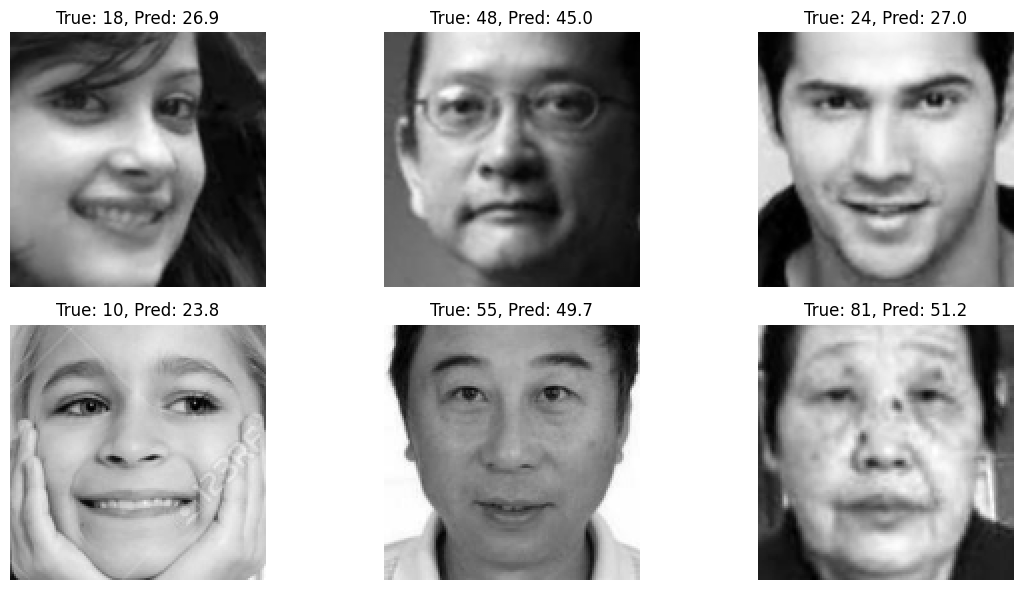

2025-04-23 22:36:21.965066: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Transfer Classifier Accuracy: 57.14% | Loss: 1.0434
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step

Transfer Classification - First 6 Predictions:
Image 0: True = 1, Pred = 2
Image 1: True = 4, Pred = 4
Image 2: True = 2, Pred = 2
Image 3: True = 0, Pred = 0
Image 4: True = 4, Pred = 4
Image 5: True = 5, Pred = 5


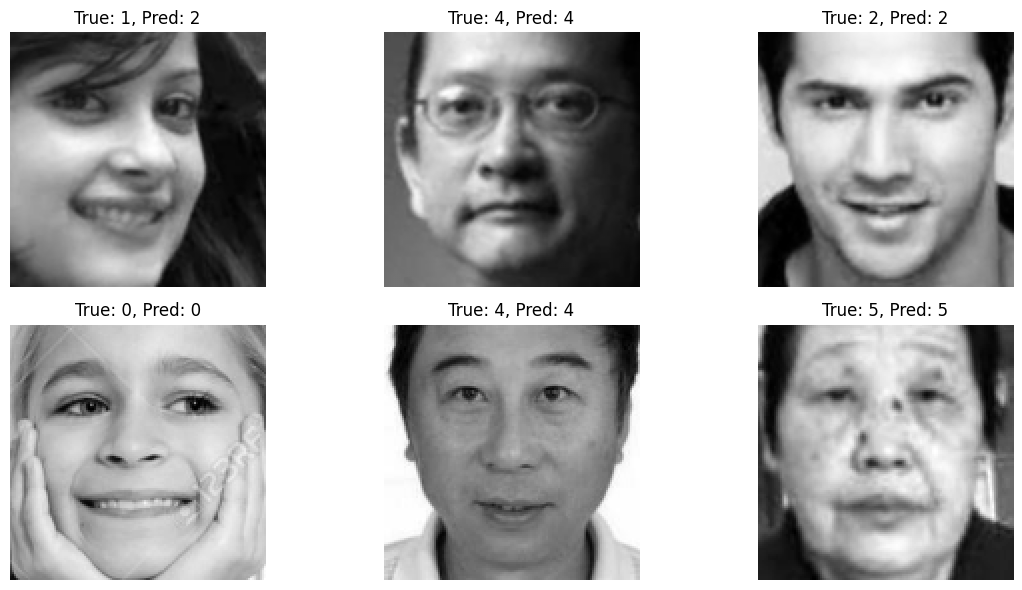

2025-04-23 22:36:30.987130: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from data_loader import load_dataset
from pathlib import Path
import os

# Confirm working directory
print("Working dir:", os.getcwd())

ROOT_PATH = Path(os.getcwd()).parent
TEST_CSV = ROOT_PATH / 'processed_csvs/test_filtered.csv'
BLOCK2_CSV = ROOT_PATH / 'processed_csvs/block2_classification.csv'

for csv_path in [TEST_CSV, BLOCK2_CSV]:
    df = pd.read_csv(csv_path)
    df['filepath'] = df['filepath'].apply(lambda x: str(ROOT_PATH / x))
    df.to_csv(csv_path, index=False)

# --- Configuration ---
IMG_SIZE = (128, 128)
GRAYSCALE = True
BATCH_SIZE = 32

REGRESSION_MODEL_PATH = ROOT_PATH / 'best_models/run17_regression_3x3_relu_128_l2_dropout.keras'
TRANSFER_CLASSIFIER_PATH = ROOT_PATH / 'best_models/labelled_transfer_classifier.keras'

# --- Load Datasets ---
test_ds_regression = load_dataset(
    csv_path=TEST_CSV,
    img_size=IMG_SIZE,
    task='regression',
    grayscale=GRAYSCALE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_transfer = load_dataset(
    csv_path=TEST_CSV,
    img_size=IMG_SIZE,
    task='classification',
    grayscale=GRAYSCALE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- Evaluate Regression Model (Run 17) ---
reg_model = tf.keras.models.load_model(REGRESSION_MODEL_PATH)
reg_results = reg_model.evaluate(test_ds_regression, verbose=0)
print(f"\nRegression MAE: {reg_results[1]:.2f} | MSE: {reg_results[0]:.2f}")

# --- Visualize Regression Predictions ---
for images, true_ages in test_ds_regression.take(1):
    predicted_ages = reg_model.predict(images).flatten()

    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"True: {int(true_ages[i])}, Pred: {predicted_ages[i]:.1f}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- Evaluate Transfer Classifier (Autoencoder Encoder) ---
transfer_model = tf.keras.models.load_model(TRANSFER_CLASSIFIER_PATH)
clf_results = transfer_model.evaluate(test_ds_transfer, verbose=0)
print(f"\nTransfer Classifier Accuracy: {clf_results[1]*100:.2f}% | Loss: {clf_results[0]:.4f}")

# --- Visualize Transfer Classification Predictions ---
for images, labels in test_ds_transfer.take(1):
    preds = transfer_model.predict(images)
    pred_classes = tf.argmax(preds, axis=1)
    true_classes = tf.argmax(labels, axis=1)

    print("\nTransfer Classification - First 6 Predictions:")
    for i in range(6):
        print(f"Image {i}: True = {true_classes[i].numpy()}, Pred = {pred_classes[i].numpy()}")

    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"True: {true_classes[i]}, Pred: {pred_classes[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()